# Определение возраста покупателей с помощью нейросети ResNet

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. 

Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя. 
Постройте модель, которая по фотографии определит приблизительный возраст человека.

**Данные:** в нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

Импорт библиотек.

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.image as mpimg

RANDOM_STATE=42

In [2]:
dataframe = pd.read_csv('/datasets/faces/labels.csv')
dataframe.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В датафрейме с метками и номерами фото нет пропусков. Проверим номера на дубликаты.

In [4]:
dataframe['file_name'].duplicated().sum()
#dataframe['file_name'].is_monotonic_increasing

0

Дубликатов нет.

In [5]:
datagen = ImageDataGenerator(rescale=1./255)  

generator = datagen.flow_from_dataframe(
    dataframe=dataframe,
    directory='/datasets/faces/final_files',  
    x_col='file_name', 
    y_col='real_age',   
    target_size=(150, 150),  
    batch_size=32,  
    class_mode='raw',  
    shuffle=True,  
    seed=12345  
)

Found 7591 validated image filenames.


Размер выборки - 7591 изображение.

Построим график распределения возраста в выборке.

In [13]:
def hist_box(df,column):
    fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (18,8))
    sns.histplot(data = df,x = column, ax=axs[0], bins = 40, kde=True)
    axs[0].set_xlabel(column)
    axs[0].set_ylabel('Количество')
    axs[0].set_title('Гистограмма')
    axs[0].grid(True) 
    sns.boxplot(data = df,x = column, ax=axs[1])
    axs[1].set_xlabel(column)
    axs[1].set_title('Диаграмма размаха')
    fig.suptitle(f'Гистограмма и диаграмма размаха для {column}')
    plt.show()
    print(df[column].describe())

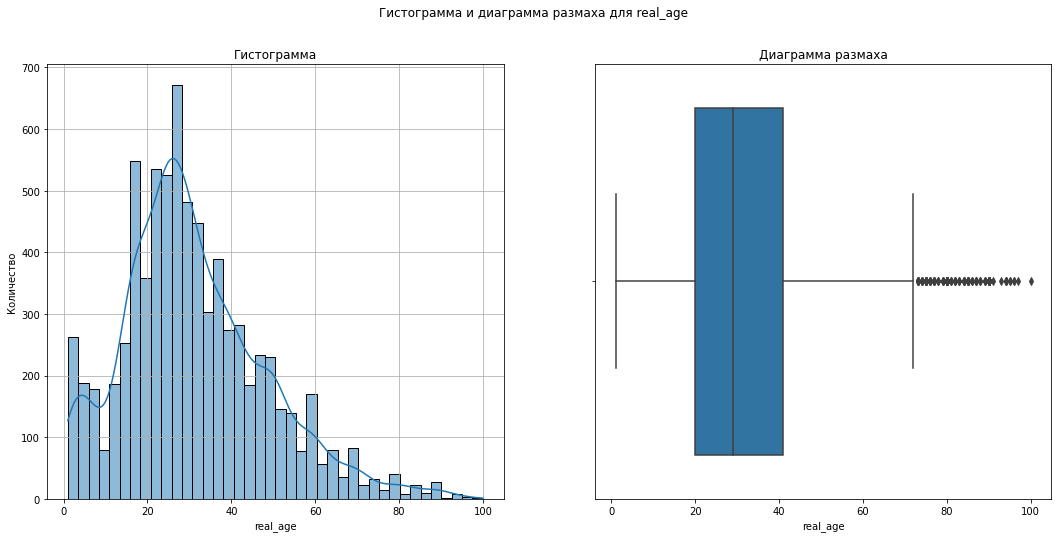

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


In [14]:
hist_box(dataframe,'real_age')

На диаграмме размаха присутствуют выбросы, но они не выглядят аномалиями, оставим их.

Возраст людей в данном наборе данных варьируется от 1 до 100 лет. Средний возраст составляет около 31 года, а медиана 29 лет - большинство записей относятся к взрослым или молодым людям. Стандартное отклонение указывает на значительный разброс возрастов.

Напечатаем на экране 10–15 фотографий и посмотрим, как устроен датасет.

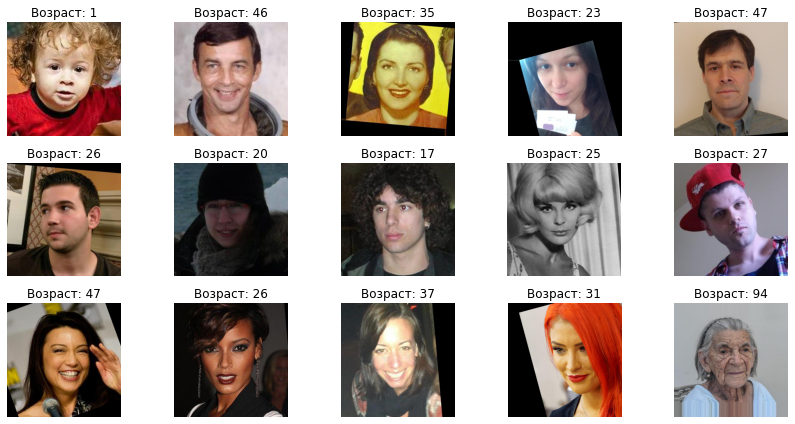

In [8]:
random_images = dataframe.sample(n=15, random_state=RANDOM_STATE)

fig, axes = plt.subplots(3, 5, figsize=(12, 6)) 
for ax, (index, row) in zip(axes.flatten(), random_images.iterrows()):
    img_path = os.path.join('/datasets/faces/final_files', row['file_name'])
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(f'Возраст: {row["real_age"]}')
    ax.axis('off')  

plt.tight_layout()
plt.show()

**Вывод:** Размер выборки - 7591 изображение. В датасете с номерами фото и метками возраста нет пропусков и дубликатов. Возраст людей в данном наборе данных варьируется от 1 до 100 лет. Средний возраст составляет около 31 года, а медиана 29 лет - большинство записей относятся к взрослым или молодым людям. Стандартное отклонение указывает на значительный разброс возрастов. 

Фотографии разные по цветовой гамме, яркости, насыщенности, четкости, освещенности, фону, углу съемки, некоторые изображения имеют наклон. На фото действительно изображены люди разного возраста обоих полов, с разными эмоциями и внешностью (цветом волос, глаз, прической, с макияжем и без), что делает данные подходящими для обучения.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

In [9]:
#```python


from tensorflow.keras import Sequential  
from tensorflow.keras.layers import Flatten, Dense,   GlobalAveragePooling2D  
import numpy as np  
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras.applications.resnet import ResNet50  
import pandas as pd  


def load_train(path):  
    datagen = ImageDataGenerator(validation_split=0.25,   rescale=1./255, horizontal_flip=True)    
    labels = pd.read_csv(path + 'labels.csv')    
    train_datagen_flow =   datagen.flow_from_dataframe(dataframe=labels,  
                                                     directory=path + 'final_files/',   
                                                     x_col='file_name',  
                                                     y_col='real_age',  
                                                     target_size=(224, 224),   
                                                     batch_size=16,   
                                                     class_mode='raw',   
                                                     subset='training',  
                                                     seed=12345)    
    return train_datagen_flow  


def load_test(path):    
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)  
    labels = pd.read_csv(path + 'labels.csv')  
    test_datagen_flow = datagen.flow_from_dataframe(dataframe=labels,  
                                                     directory=path + 'final_files/',   
                                                     x_col='file_name',  
                                                     y_col='real_age',   
                                                     target_size=(224, 224),   
                                                     batch_size=16,   
                                                     class_mode='raw',   
                                                     subset='validation',  
                                                     seed=12345)  
    return test_datagen_flow  


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu')) 
 
    optimizer = Adam(lr=0.0001) 
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model
#```

```

2025-02-11 14:21:39.825254: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2025-02-11 14:21:39.825304: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2025-02-11 14:21:39.825314: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2025-02-11 14:21:39.828476: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-02-11 14:21:39.828530: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 22s
   49152/94765736 [..............................] - ETA: 1:40
  139264/94765736 [..............................] - ETA: 1:12
  368640/94765736 [..............................] - ETA: 40s 
  778240/94765736 [..............................] - ETA: 25s
 1679360/94765736 [..............................] - ETA: 14s
 4014080/94765736 [>.............................] - ETA: 7s 
 7397376/94765736 [=>............................] - ETA: 4s
10616832/94765736 [==>...........................] - ETA: 3s
13787136/94765736 [===>..........................] - ETA: 2s
16982016/94765736 [====>.........................] - ETA: 2s
20119552/94765736 [=====>........................] - ETA: 2s
23248896/94765736 [======>.......................] - ETA: 1s
26484736/94765736 [=======>......................] - ETA: 1s
29622272/94765736 [========>.....................] - ETA: 1s
32645120/94765736 [=========>....................] - ETA: 1s
35799040/94765736 [==========>...................] - ETA: 1s
39354368/94765736 [===========>..................] - ETA: 1s
42549248/94765736 [============>.................] - ETA: 1s
45744128/94765736 [=============>................] - ETA: 1s
49020928/94765736 [==============>...............] - ETA: 0s
52224000/94765736 [===============>..............] - ETA: 0s
55107584/94765736 [================>.............] - ETA: 0s
58531840/94765736 [=================>............] - ETA: 0s
62103552/94765736 [==================>...........] - ETA: 0s
65331200/94765736 [===================>..........] - ETA: 0s
68730880/94765736 [====================>.........] - ETA: 0s
72040448/94765736 [=====================>........] - ETA: 0s
74973184/94765736 [======================>.......] - ETA: 0s
77881344/94765736 [=======================>......] - ETA: 0s
81313792/94765736 [========================>.....] - ETA: 0s
84467712/94765736 [=========================>....] - ETA: 0s
87203840/94765736 [==========================>...] - ETA: 0s
90177536/94765736 [===========================>..] - ETA: 0s
93233152/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 2s 0us/step
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/5
2025-02-11 14:21:55.518924: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-02-11 14:21:55.842484: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 66s - loss: 229.6088 - mae: 10.8164 - val_loss: 333.6417 - val_mae: 13.5207
Epoch 2/5
356/356 - 47s - loss: 70.7941 - mae: 6.4170 - val_loss: 166.1688 - val_mae: 9.5306
Epoch 3/5
356/356 - 48s - loss: 36.8705 - mae: 4.7186 - val_loss: 69.8824 - val_mae: 6.3454
Epoch 4/5
356/356 - 51s - loss: 23.6737 - mae: 3.7715 - val_loss: 81.2992 - val_mae: 6.7101
Epoch 5/5
356/356 - 50s - loss: 17.9500 - mae: 3.2398 - val_loss: 81.9147 - val_mae: 7.0661
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 12s - loss: 81.9147 - mae: 7.0661

```

## Анализ обученной модели

В проекте была поставлена задача регрессии, необходимо было обучить модель определять возраст по фото. В качестве основы (backbone) модели была использована нейронная сеть Resnet50 , предобученная на датасете ImageNet - были использованы ее веса на этом датасете. Верхняя часть модели не была включена, так как были созданы верхние слои (голова) под нашу задачу: GlobalAveragePooling2D, чтобы усреднить информацию по всему изображению и полносвязный слой с одним выходом с активацией 'relu'.
Заморозка весов бэкбона не была применена, чтобы позволить модели дообучать все слои ResNet50 на новых данных.

Размер батча установлен на 16. Использовался оптимизатор Adam с шагом обучения 0.0001. Модель была обучена на 5 эпохах. Условие "метрика должна быть не меньше 8" было достигнуто на 3й эпохе. На четвертой и пятой эпохах val_mae стала немного увеличиваться, скорее всего модель начала переобучаться.

Средняя абсолютная ошибка MAE равна 7.0661, что означает, что в среднем модель предсказывает возраст с ошибкой примерно в 7 лет. 
В контексте нашей задачи ошибка в 7 лет может быть приемлемой или неприемлемой в зависимости от специфики бизнеса и целей использования модели. Например, если для вашей задачи критично знать точный возраст клиента, то такая ошибка может быть слишком большой. В то же время, если это всего лишь один из факторов в более сложной системе рекомендаций, то такая ошибка может быть вполне допустимой.